In [2]:
import carla 
import math 
import random 
import time 
import numpy as np
import cv2
from PIL import Image
# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', 2000) 
world = client.get_world()
bp_lib = world.get_blueprint_library()  
spawn_points = world.get_map().get_spawn_points() 

In [3]:
def depthimage(rgb,depthmap):
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    B = rgb[:,:,2]

    normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
    in_meters = 1000 * normalized
    in_meters = in_meters.reshape((in_meters.shape[0], in_meters.shape[1], 1))
    # output = np.concatenate([rgb[:,:,:3], in_meters],axis = 2)
    # return output
    return in_meters


In [4]:
# Add the ego vehicle
vehicle_bp = bp_lib.find('vehicle.lincoln.mkz_2020') 
vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[79])

# Move the spectator behind the vehicle to view it
spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),vehicle.get_transform().rotation) 
spectator.set_transform(transform)


In [5]:
# Set initial camera translation
camera_init_trans = carla.Transform(carla.Location(z=2))

# Add one of each type of camera
camera_bp = bp_lib.find('sensor.camera.rgb') 
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)

depth_camera_bp = bp_lib.find('sensor.camera.depth') 
depth_camera = world.spawn_actor(depth_camera_bp, camera_init_trans, attach_to=vehicle)


In [6]:
# Define respective callbacks
def rgb_callback(image, data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))
    # image.save_to_disk('rgb_out/%06d.png' % image.frame)
def depth_callback(image, data_dict):
    image.convert(carla.ColorConverter.LogarithmicDepth)
    data_dict['depth_image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))
    

In [7]:
dict = {}
# dict['get_transform']  = []

In [9]:
# Initialise parameters and data
image_w = camera_bp.get_attribute("image_size_x").as_int()
image_h = camera_bp.get_attribute("image_size_y").as_int()


sensor_data = {'rgb_image': np.zeros((image_h, image_w, 4)),
               'depth_image': np.zeros((image_h, image_w, 4))}

# OpenCV named window for display
# cv2.namedWindow('All cameras', cv2.WINDOW_NORMAL)

# Tile all data in one array
top_row = sensor_data['rgb_image']
lower_row = sensor_data['depth_image']
tiled = np.concatenate((top_row, lower_row), axis=0)

# Display with imshow
# cv2.imshow('All cameras',sensor_data['rgb_image'])
# cv2.waitKey(1)
# world.get_actor().set_autopilot(True)
vehicle.set_autopilot(True)
# Set sensors recording
camera.listen(lambda image: rgb_callback(image, sensor_data))
depth_camera.listen(lambda image: depth_callback(image, sensor_data))

# Build the intrinsic matrix:
# K = [[Fx,  0, image_w/2],
#      [ 0, Fy, image_h/2],
#      [ 0,  0,         1]]
# image_w = camera.get_attribute("image_size_x").as_int()
# image_h = camera.get_attribute("image_size_y").as_int()
fov = camera_bp.get_attribute("fov").as_float()
focal = image_w / (2.0 * np.tan(fov * np.pi / 360.0))

# In this case Fx and Fy are the same since the pixel aspect
# ratio is 1
K = np.identity(3)
K[0, 0] = K[1, 1] = focal
K[0, 2] = image_w / 2.0
K[1, 2] = image_h / 2.0
# depthimage(sensor_data['rgb_image'],sensor_data['depth_image'])
# Indefinite while loop
# while True:
dict = {'intrinsic':K,'extrinsic':[],'depth':[],'rgb':[],'position':[],'get_transfrom':[]}
for i in range(0,10):
    
    # Tile camera images into one array
    top_row = sensor_data['rgb_image']
    lower_row = sensor_data['depth_image']
    tiled = np.concatenate((top_row, lower_row), axis=1)
    print(camera.get_transform().location.x)

    # depth = depthimage(sensor_data['rgb_image'],sensor_data['depth_image'])
    depth = sensor_data['depth_image']
    # Dispaly with imshow
    # cv2.imshow('All cameras',tiled)
    i += 1
    # Break loop if user presses q
    # if cv2.waitKey(1) == ord('q'):
    #     break
    # top_row.save_to_disk('rgb_out/%06d.png' % i)
    
    # This (4, 4) matrix transforms the points from world to sensor coordinates.
    world_2_camera = np.array(camera.get_transform().get_inverse_matrix())

    # # New we must change from UE4's coordinate system to an "standard"
    # # camera coordinate system (the same used by OpenCV):

    # # ^ z                       . z
    # # |                        /
    # # |              to:      +-------> x
    # # | . x                   |
    # # |/                      |
    # # +-------> y             v y

    # # This can be achieved by multiplying by the following matrix:
    # # [[ 0,  1,  0 ],
    # #  [ 0,  0, -1 ],
    # #  [ 1,  0,  0 ]]

    cameraR = np.array([[0,1,0,0],[0,0,-1,0],[1,0,0,0],[0,0,0,1]])@world_2_camera
    # print("world2camera",world_2_camera)
    # print(cameraR)
    dict['depth'].append(depth)
    # dict['rgb'].append(sensor_data['rgb_image'])
    dict['extrinsic'].append(cameraR)
    dict['position'].append(np.array([camera.get_transform().location.x,camera.get_transform().location.y,camera.get_transform().location.z]))
    # image = Image.fromarray(sensor_data['rgb_image'][0,2,1,3])
    # image.save("rgb_out/%08d.png" %i)
    print(camera.get_transform().get_matrix())
    dict['get_transfrom'].append(np.array(camera.get_transform().get_matrix()))
    cv2.imwrite("rgb_out/%03d.png"%i, sensor_data['rgb_image'])
# Stop sensors and destroy OpenCV window
camera.stop()
depth_camera.stop()
# cv2.destroyAllWindows()

-13.530436515808105
[[0.9999890923500061, 0.0014140239218249917, -0.004442755598574877, -13.530436515808105], [-0.0014082648558542132, 0.999998152256012, 0.0012991175753995776, 28.142107009887695], [0.004444584716111422, -0.0012928468640893698, 0.9999892711639404, 1.9943767786026], [0.0, 0.0, 0.0, 1.0]]
-13.530436515808105
[[0.9999890923500061, 0.0014140239218249917, -0.004442755598574877, -13.530436515808105], [-0.0014082648558542132, 0.999998152256012, 0.0012991175753995776, 28.142107009887695], [0.004444584716111422, -0.0012928468640893698, 0.9999892711639404, 1.9943767786026], [0.0, 0.0, 0.0, 1.0]]
-12.93964958190918
[[0.9999375939369202, 0.009062637574970722, -0.006529568694531918, -12.93964958190918], [-0.0090480362996459, 0.999956488609314, 0.002262410707771778, 28.13269805908203], [0.006549788173288107, -0.002203189767897129, 0.9999760985374451, 1.993902564048767], [0.0, 0.0, 0.0, 1.0]]
-12.93964958190918
[[0.9999375939369202, 0.009062637574970722, -0.006529568694531918, -12.93

In [10]:
import matplotlib.pyplot as plt

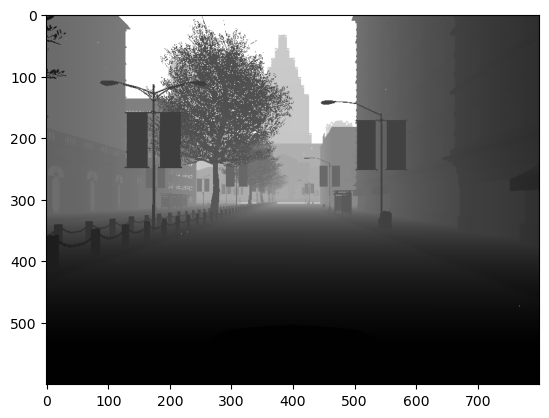

In [13]:
plt.imshow(dict['depth'][1])

In [14]:
camera.get_transform().get_matrix()

[[-0.48904311656951904,
  -0.8722590804100037,
  0.0009806875605136156,
  95.51276397705078],
 [0.8722580671310425,
  -0.48904404044151306,
  -0.001353801810182631,
  115.44944763183594],
 [0.0016604652628302574,
  0.00019334517128299922,
  0.9999986290931702,
  1.9948526620864868],
 [0.0, 0.0, 0.0, 1.0]]

In [15]:
camera.stop()
depth_camera.stop()

In [17]:
# # Destroy actors
vehicle.destroy()
# world.get_actor().filter('vehicle').destroy()

True

In [18]:
import pickle


with open('10frame.pickle', 'wb') as f:
    pickle.dump(dict, f)

: 

In [1]:
import pickle
with open('10frame.pickle', 'rb') as f:
    a = pickle.load(f)